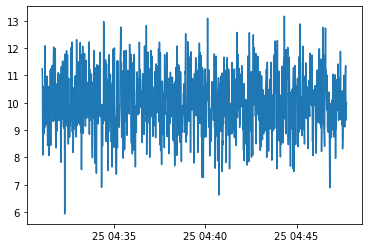

In [16]:
import numpy as np
import pandas as pd
from numpy import sqrt
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

t0 = int(datetime.now().timestamp())
n = 1000
time = [datetime.utcfromtimestamp(t) for t in range(t0, t0+n)]
vol = .030
lag = 300
views = np.random.randn(n) * sqrt(vol) * sqrt(1 / 252.)*100+10
train = pd.DataFrame({'time':time, 'view':views})

plt.plot(train.time, train.view)
plt.show()

## Pre-processing Data
### Standardization
**Normally distrbuted data** - Gaussian with zero mean and unit variance
Many elements used in the objective function of a learning algorithm (such as the RBF kernel of SVM) assume that all features are centered around zero and have variance in the same order.

You can use the **scale** function to achieve zero mean and variance data:


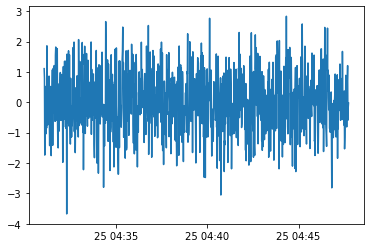

In [18]:
from sklearn import preprocessing
import numpy as np
scaled = preprocessing.scale(train.view)

plt.plot(train.time, scaled)
plt.show()

You can use a **Transformer** to record compute the mean and sd and later apply the transformation on the testing set.  Note that *fit()* expected a 2D numpy array not a 1D array.  You must call reshape on the 1D array first before passing it to fit.

In [27]:
X_train = train.view.values.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(X_train)
print(scaler.mean_)
print(scaler.scale_)
scaler.transform(X_train)[0:10]

[10.0182429]
[1.11076688]


array([[ 1.10869111],
       [ 0.78975146],
       [-1.73962544],
       [-0.52696007],
       [-0.44268382],
       [-0.41034127],
       [-1.03781146],
       [ 0.53587493],
       [-0.84816781],
       [ 1.86063497]])

Simliarly, there are some other useful encoders that records the transformation and can be re-applied to another dataset later

In [42]:
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#weekdays = [d.strftime('%a')for d in train.time]
#weekdays_labels = LabelEncoder().fit_transform(weekdays).reshape(-1, 1)
#print(weekdays_labels[0:5])

weekdays_encoded = OneHotEncoder(sparse=False).fit_transform(
    np.array(weekdays).reshape(-1, 1))
print(weekdays_encoded[0:5])
# np.expand_dims(weekdays_encoded,0)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
# Create an array to discover lagged features

# Some functions for auto correlations
def lag_arr(arr, lag, fill):
    filler = np.full((arr.shape[0],lag,1),-1)
    comb = np.concatenate((filler,arr),axis=1)
    result = comb[:,:arr.shape[1]]
    return result

def single_autocorr(series, lag):
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

def batc_autocorr(data,lag,series_length):
    corrs = []
    for i in range(data.shape[0]):
        c = single_autocorr(data, lag)
        corrs.append(c)
    corr = np.array(corrs)
    corr = np.expand_dims(corr,-1)
    corr = np.expand_dims(corr,-1)
    corr = np.repeat(corr,series_length,axis=1)
    return corr

## Conv1D

Similar to 2D Convolution Neural Networks, there is also aversion of convolutional filters that can slide over a sequence one-dimensionally.


In [ ]:
n_features = 29
max_len = 100


# Compile the model
model = Sequential()
model.add(Conv1D(16,5, input_shape=(100,29)))
model.add(Activation('relu'))
model.add(MaxPool1D(5))

model.add(Conv1D(16,5))
model.add(Activation('relu'))
model.add(MaxPool1D(5))
model.add(Flatten()) # Transforms a tensor into a flat tensor 
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_absolute_percentage_error')


# Train the model
from sklearn.model_selection import train_test_split

batch_size = 128
train_df, val_df = train_test_split(train, test_size=0.1)
train_gen = generate_batches(train_df,batch_size=batch_size)
val_gen = generate_batches(val_df, batch_size=batch_size)

n_train_samples = train_df.shape[0]
n_val_samples = val_df.shape[0]


## RNN Recurrent Neural Network
 - This network contains recurrent layers that can remember their last activation and use it as their own input.  A recurrent layer takes a sequence as an input.  For each element, it then computes a matrix multiplication (like a Dense layer), and runs the results through an activation such as relu.

In [ ]:
from keras.layers import SimpleRNN

# Compile the model
model = Sequential()
model.add(SimpleRNN(16,return_sequences=True,input_shape=(max_len,n_features)))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(64))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_absolute_percentage_error')

# Trains the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).

model.fit_generator(train_gen,epochs=20,steps_per_epoch=n_train_samples // batch_size, validation_data= val_gen, validation_steps=n_val_samples // batch_size)
